In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch
import torch.nn.functional as F

from scipy.stats import pearsonr
from scipy.stats import t
from skimage import morphology, filters
from nilearn.datasets import fetch_haxby
from nilearn import input_data, plotting, image
from matplotlib import colors
from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.plotting.img_plotting import plot_epi, plot_roi

from skimage import morphology, filters

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import statsmodels.stats.multitest as multitest
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import Covariances
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Shrinkage

from utils import extract_segments, show_scan_slices
from dataloader import haxby_dataset


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
%load_ext autoreload
%autoreload 2

In [2]:
import pkg_resources
packages = ['numpy', 'pandas', 'matplotlib', 'nilearn', 'torch', 'pyriemann', 'statsmodels', 'scikit-learn', 'scikit-image']

for package in packages:
    dist = pkg_resources.get_distribution(package)
    version = dist.version
    print(f'{package}=={version}')

numpy==1.23.5
pandas==2.0.3
matplotlib==3.7.5
nilearn==0.10.3
torch==1.13.1
pyriemann==0.5
statsmodels==0.14.1
scikit-learn==1.0.2
scikit-image==0.18.1


In [3]:
warnings.filterwarnings('ignore')

### [Haxby datset](http://www.pymvpa.org/datadb/haxby2001.html)

Во время эксперимента испытуемым показывали различные изображения. Категории изображений представляются в метках, а именно каждая метка соответствует определенной категории изображений. Например, если в эксперименте использовались изображения различных объектов, метки могут обозначать какие-то определенные объекты. Таким образом, задача классификации заключается в том, чтобы по фМРТ-снимкам предсказать, какой класс картинок наблюдал испытуемый.

Классы:
- bottle
- cat
- chair
- face
- house
- scissors
- scrambledpix
- shoe

Также присутствует rest, когда испытуемому ничего не показывали

In [3]:
dataset = haxby_dataset()

# Пути к файлам датасета
datafiles = dataset.data_files

# Описание датасета
#print(datafiles['description'])

# Отрисовка примеров стимулов
#dataset.plot_stimuli()

Получим данные первого испытуемого

In [4]:
fmris, labels = dataset.get_sub_data(1)

In [5]:
fmris.shape

(40, 64, 64, 1452)

In [190]:
labels.head()

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


Каждая запись имеет длину 121

In [107]:
chunks = labels['chunks'].values
print(len(chunks[chunks==0]))

121


In [108]:
labels[:121]['labels'].values

array(['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'house', 'house',
       'house', 'house', 'house', 'house', 'house', 'house', 'house',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'scrambledpix',
       'scrambledpix', 'scrambledpix', 'scrambledpix', 'scrambledpix',
       'scrambledpix', 'scrambledpix', 'scrambledpix', 'scrambledpix',
       'rest', 'rest', 'rest', 'rest', 'rest', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'face', 'rest', 'rest',
       'rest', 'rest', 'rest', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe',
       'shoe', 'shoe', 'shoe', 'shoe', 'rest', 'rest', 'rest', 'rest',
       'rest', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair',
       'chair', 'chair', 'chair', 'rest', 'rest', 'rest', 'rest', 'rest',
       'rest', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'rest', 'rest', 'rest', 'rest', 'rest', 'bottle', 'bottle',
       'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle',
     

---

### Маски активности
A common operation in fMRI analyses is masking: extracting particular voxels from the entire dataset, usually based on a binary brain mask. Masking, at least in fMRI analyses, is often done on the spatial dimensions of 4D images; as such, masking can be seen as a operation that takes in a 4D image with spatial dimensions  X×Y×Z  and temporal dimension  T  and returns a  T×K  2D array, where  K  is the number of voxels that "survived" (for lack of a better word) the masking procedure.

Reasons to mask your data could be, for example, to exclude non-brain voxels (like in skullstripping) or to perform confirmatory region-of-interest (ROI) analyses, or to extract one or multiple "seed regions" for connectivity analyses.

Nilearn provides several functions and classes that perform masking, which differ in how extensive they are (some only perform masking on a single image, others do this for multiple images at the same time, and/or may additionally perform preprocessing steps). Importantly, all take in a 4D niimg-like object and return a 2D numpy array.

We'll first take a look at the most simple and low-level implementation: apply_mask. This function takes in a 4D image (which will be masked), a binary 3D image (i.e., with only zeros and ones, where ones indicate that they should be included) as mask, and optionally a smoothing kernel size (FWHM in millimeters) and returns a masked 2D array. Let's do this for our data (func_img_run1) using the brain mask (func_mask) you computed earlier.

Маска The ventral temporal cortex была создана в рамках исследования Haxby(2001) и выделяет часть мозга, специализирующуюся на обработке визуальной информации, и которая содержит области, чувствительные к различным типам категорий изображений. Далее проводим анализ для первого испытуемого

In [7]:
vt_mask_filename = load_img(datafiles.mask_vt[0])
func_filename = datafiles.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape

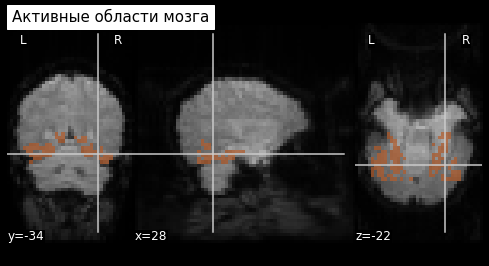

In [8]:
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Активные области мозга', draw_cross=True, 
                  cmap='Paired')

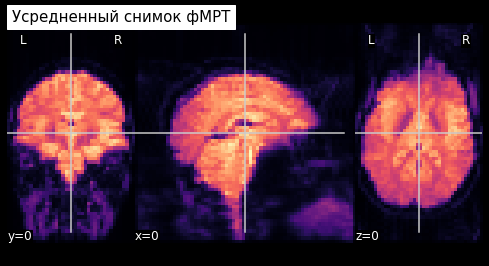

In [9]:
plot_epi(mean_haxby, cut_coords=(0, 0, 0), cmap='magma', title = 'Усредненный снимок фМРТ')

In [10]:
# Применение маски активации к фмрт снимкам
masker = input_data.NiftiMasker(mask_img=vt_mask_filename, standardize=True)
fmri_masked = masker.fit_transform(func_filename)

In [11]:
fmri_masked.shape

(1452, 577)

---

### Подготовка данных
Данные первого испытуемого хранятся в переменных fmris, labels, разделим последовательность на временные ряды по классам.
Закодируем классы следующим образом: 
- 'rest': 0
- 'bottle': 1
- 'cat': 2
- 'chair': 3
- 'face': 4
- 'house': 5
- 'scissors': 6
- 'scrambledpix': 7
- 'shoe': 8

Также обратим внимание на строение данных, до показа стимула и после показа стимула идет около 5 моментов времени отдыха. Сам же стимул демонстрируется ровно 9 моментов времени, поэтому зафиксируем $\tau = 19$.

По ссылке на haxby можно увидеть, что частота $\mu = 2.5$Гц

In [6]:
class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}

stimuli = np.array([class_dict[label] for label in labels['labels'].values])
stimuli.shape

(1452,)

In [7]:
fmris_transposed = fmris.transpose((3, 0, 1, 2))
fmris_transposed.shape

(1452, 40, 64, 64)

In [8]:
# Как мы видим тензоры фМРТ не нормированы
np.max(fmris_transposed[0])

2672.0

In [9]:
# Сегментация временного ряда по классам стимулов
X, s, y = extract_segments(fmris_transposed, stimuli, tau=19)
y=y-1

Всего получили 96 временных рядов фМРТ длины 19, на каждый класс приходится по 12 рядов. Возможна новая проблема аугментации, которая требует отдельного решения.

---
### Тестирование метода cross-corralation weighting

In [10]:
def ccw(X, s, mu, k_s, Delta_t, h, masked_brain=False):
        # 1. Input: temporal fMRI series X with sampling rate mu and stimulus time series s
        X = torch.tensor(X).clone() # (tau, X, Y, Z)
        s = torch.tensor(s).clone() # (tau,)

        if masked_brain:
            mean_X = torch.mean(X, axis=0)
            # scaling
            mean_X = np.array((mean_X - mean_X.min()) / (mean_X.max() - mean_X.min()))

            # getting otsu threshold
            threshold = filters.threshold_otsu(mean_X)
            binary_mask = mean_X > threshold

            # smoothing
            brain_mask = morphology.binary_closing(binary_mask, morphology.ball(2))
            brain_mask = morphology.binary_opening(brain_mask, morphology.ball(2)).astype(np.int8)

        # 2. 3D Average Pooling
        X_prime = F.avg_pool3d(X, kernel_size=k_s) # (tau, X/k_s, Y/k_s, Z/k_s)

        if masked_brain:
            mean_X_prime = torch.mean(X_prime, axis=0)
            # scaling
            mean_X_prime = np.array((mean_X_prime - mean_X_prime.min()) / (mean_X_prime.max() - mean_X_prime.min()))

            # getting otsu threshold
            threshold = filters.threshold_otsu(mean_X_prime)
            binary_mask = mean_X_prime > threshold

            # smoothing
            brain_mask_pooled = morphology.binary_closing(binary_mask, morphology.ball(2))
            brain_mask_pooled = morphology.binary_opening(brain_mask_pooled, morphology.ball(2)).astype(np.int8)

        # 3. Z-normalization of time series
        X_prime_hat = ((X_prime - X_prime.mean(dim=0, keepdims=True)) / (X_prime.std(dim=0) + 1e-9)).float()
        s_hat = ((s.float() - s.float().mean()) / s.float().std()).float()

        # 4. Cross-correlation computation
        tau = X_prime_hat.shape[0]
        C = torch.zeros((tau-1, X_prime_hat.shape[1], X_prime_hat.shape[2], X_prime_hat.shape[3]))
        for p in range(tau-1):
            C[p] = torch.einsum('i,itxy->txy', s_hat[:tau-p], X_prime_hat[p:]) / (tau-1)
        

        # 5. BOLD Delay and mask computation
        p_BOLD = int(np.floor(Delta_t * mu))
        C_p_BOLD = C[p_BOLD]

        if masked_brain:
            C_p_BOLD = C_p_BOLD * torch.tensor(brain_mask_pooled)

        _, top_h_indices = torch.topk(C_p_BOLD.view(-1), h)
        M_c = torch.zeros_like(C_p_BOLD)
        M_c.view(-1)[top_h_indices] = 1

        # 6. Perform statistical test and Holm's method
        p_values = np.zeros((X_prime_hat.shape[1], X_prime_hat.shape[2], X_prime_hat.shape[3]))
        for i in range(X_prime_hat.shape[1]):
            for j in range(X_prime_hat.shape[2]):
                for k in range(X_prime_hat.shape[3]):
                    # Perform statistical test
                    _, p_value = pearsonr(s_hat.numpy(), X_prime_hat[:, i, j, k].numpy(), alternative='greater')
                    p_values[i, j, k] = p_value

        # Apply Holm's method for multiple comparisons
        p_values_flattened = p_values.flatten()
        _, corrected_p_values, _, _ = multitest.multipletests(p_values_flattened, method='holm')
        #_, corrected_p_values, _, _ = multitest.multipletests(p_values_flattened, method='fdr_bh')

        # Reshape and replace original p_values
        corrected_p_values = corrected_p_values.reshape(p_values.shape)
        p_values = corrected_p_values
        # Upsample
        p_values = F.upsample(torch.tensor(p_values).unsqueeze(0).unsqueeze(0), size=(X.shape[1], X.shape[2], X.shape[3]), mode='nearest')
        p_values = p_values.squeeze(0).squeeze(0)

        # 7. Upsample
        #M = F.upsample(M_c.unsqueeze(0).unsqueeze(0), size=(X.shape[1], X.shape[2], X.shape[3]), mode='nearest')
        #M = M.squeeze(0).squeeze(0)

        # 8. Brain mask smoothing
        if masked_brain:
            M = M * torch.tensor(brain_mask)

        return M_c.numpy(), C_p_BOLD.numpy(), p_values.numpy()

In [196]:
def plot_ccw_results(X, s, mu, k_s, Delta_t, h, masked_brain=False, mode_delta=False):
    M, C, p_values = ccw(X, s, mu, k_s, Delta_t, h, masked_brain)
    if mode_delta:
        show_scan_slices(fmris_transposed[0], [28, 20, 24], M, title='Mask by top h correlations')
    else:
        show_scan_slices(X[0], [28, 20, 24], M, title='Mask by top h correlations')
    show_scan_slices(C, [28//k_s, 20//k_s, 24//k_s], title='Voxel-to-stimulus correlations')
    show_scan_slices(X[0], [28, 20, 24], p_values<0.05, title='Mask obtained from rejected hypotheses')
    print(f'Число областей полученных при статистическом анализе: {np.sum(p_values<0.05)}')

In [197]:
def get_otsu_brain_mask(X):
    # Выбираем временной ряд фМРТ в виде 4D-массива NumPy
    # Вычисляем среднее изображение по всему временному ряду
    mean_X = np.mean(X, axis=0)
    mean_X = (mean_X - mean_X.min()) / (mean_X.max() - mean_X.min())

    # Применяем метод Оцу для автоматического подбора порога
    threshold = filters.threshold_otsu(mean_X)
    binary_mask = mean_X > threshold

    # Применяем морфологические операции для удаления шумов и заполнения пустот в маске
    brain_mask = morphology.binary_closing(binary_mask, morphology.ball(2))
    brain_mask = morphology.binary_opening(brain_mask, morphology.ball(2)).astype(np.int8)
    return brain_mask

---

#### Пример применения метода на всем временном ряду испытуемого:

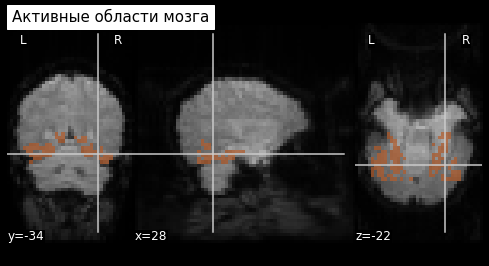

In [24]:
vt_mask_filename = load_img(datafiles.mask_vt[0])
func_filename = datafiles.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Активные области мозга', draw_cross=True, 
                  cmap='Paired')

In [23]:
fmris_transposed.shape

(1452, 40, 64, 64)

In [199]:
#plot_ccw_results(X=fmris_transposed[:121], s=bin_stimuli[:121], mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

In [214]:
bin_stimuli = stimuli.copy()
bin_stimuli[bin_stimuli!=0]=1

#plot_ccw_results(X=fmris_transposed[:121], s=bin_stimuli[:121], mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)
#plot_ccw_results(X=np.diff(fmris_transposed, axis=0), s=np.diff(bin_stimuli), mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

#### Применим метод на небольшом временному ряду фМРТ, который соотвествует определенному стимулу:

#### Cat

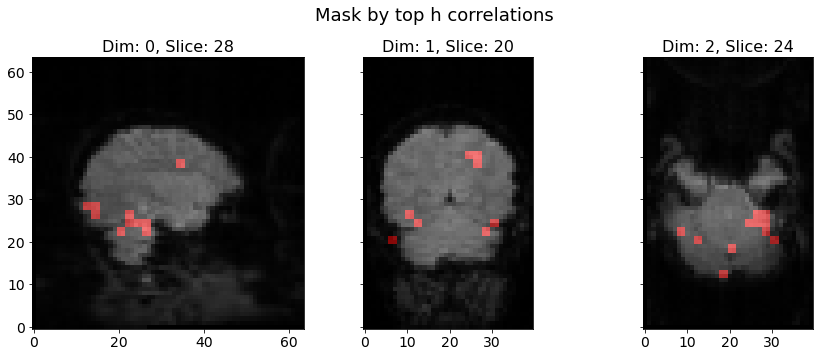

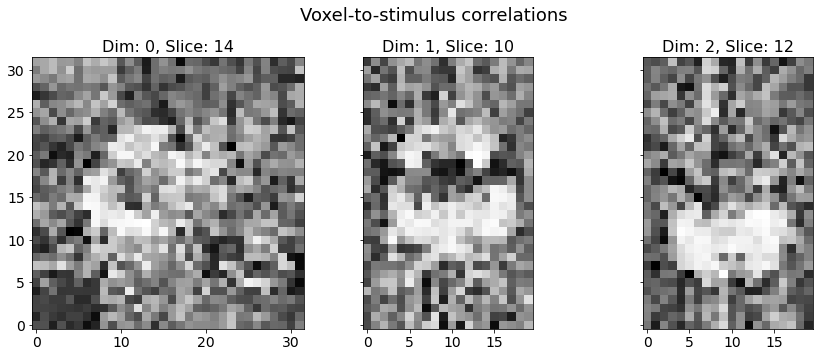

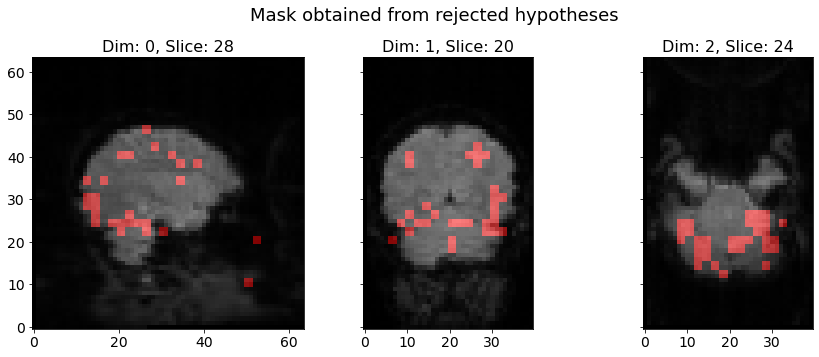

Число областей полученных при статистическом анализе: 1824


In [29]:
fMRI_cat = X[12]
s_cat = s[12]
s_cat[s_cat!=0]=1

plot_ccw_results(X=fMRI_cat, s=s_cat, mu=2.5, k_s=2, Delta_t=0, h=60, masked_brain=False)

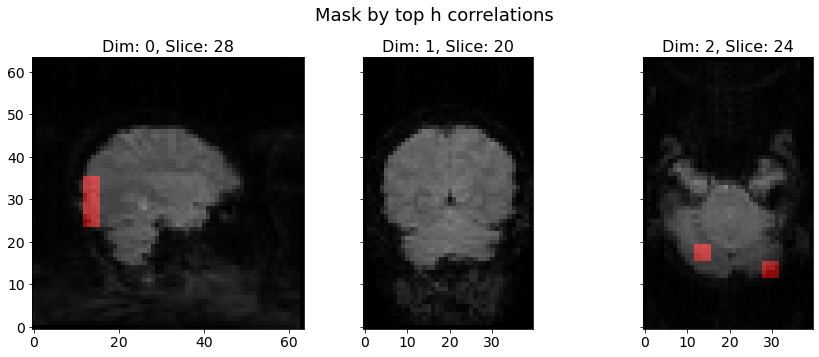

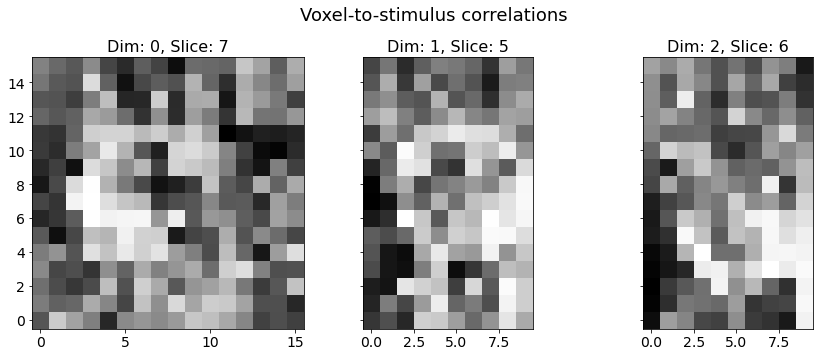

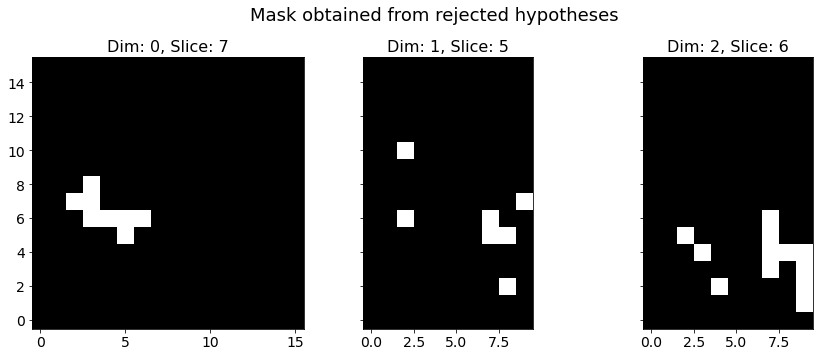

Число областей полученных при статистическом анализе: 35


In [219]:
fMRI_cat = X[20]
s_cat = s[20]
s_cat[s_cat!=0]=1

plot_ccw_results(X=fMRI_cat, s=s_cat, mu=2.5, k_s=4, Delta_t=0, h=5, masked_brain=False)

#### Bottle

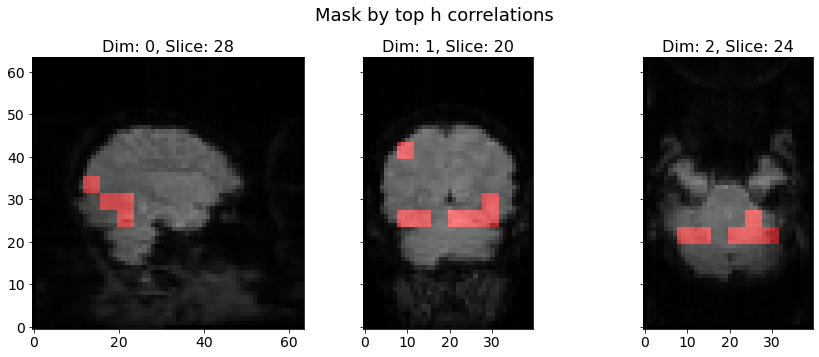

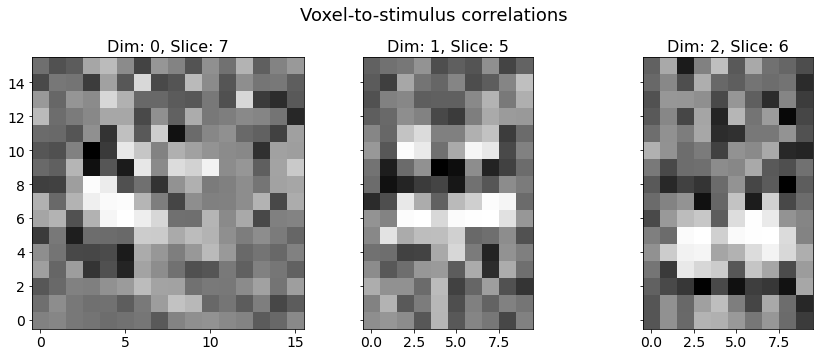

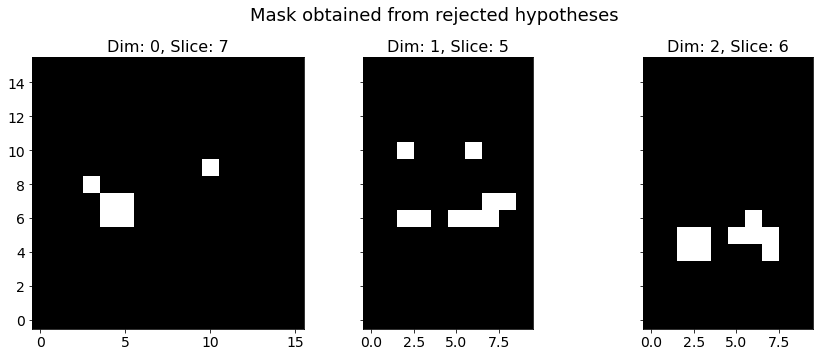

Число областей полученных при статистическом анализе: 30


In [221]:
fMRI_bottle = X[0]
s_bottle = s[0]
s_bottle[s_bottle!=0]=1

plot_ccw_results(X=fMRI_bottle, s=s_bottle, mu=2.5, k_s=4, Delta_t=0, h=15, masked_brain=False)

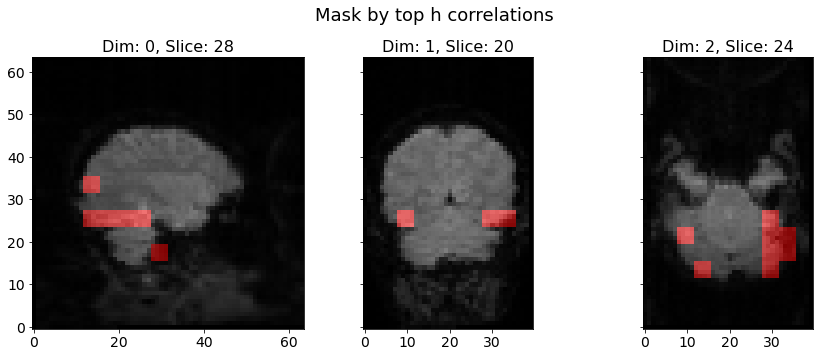

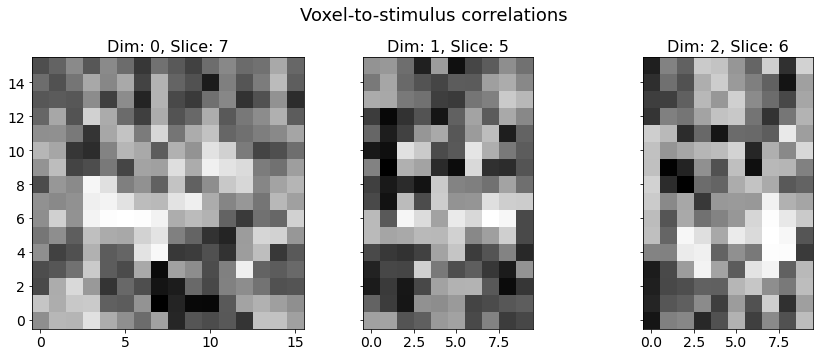

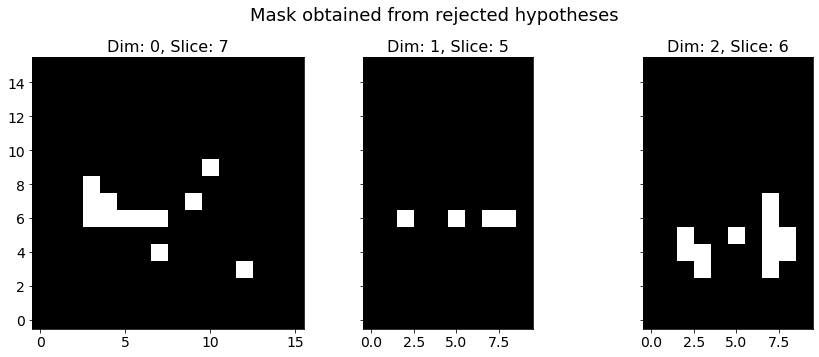

Число областей полученных при статистическом анализе: 33


In [224]:
fMRI_bottle = X[4]
s_bottle = s[4]
s_bottle[s_bottle!=0]=1

plot_ccw_results(X=fMRI_bottle, s=s_bottle, mu=2.5, k_s=4, Delta_t=0, h=15, masked_brain=False)

#### Faces

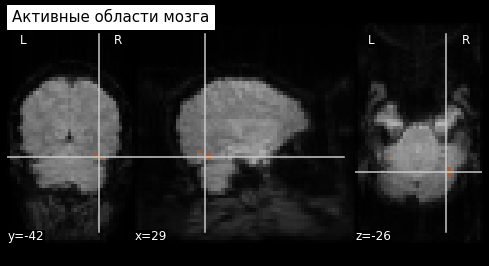

In [225]:
vt_mask_filename = load_img(datafiles['mask_face'][0])
func_filename = datafiles.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Активные области мозга', draw_cross=True, 
                  cmap='Paired')

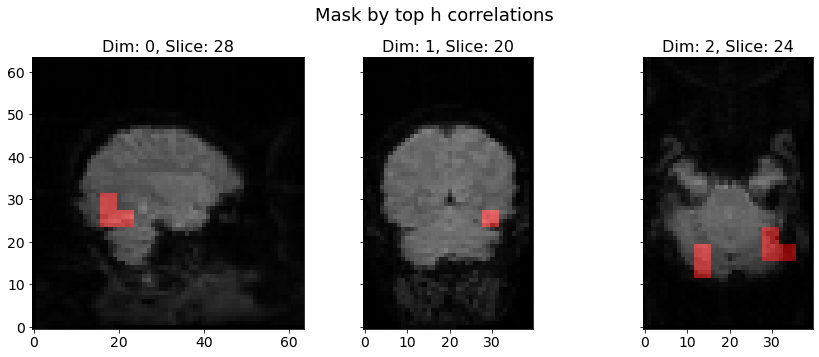

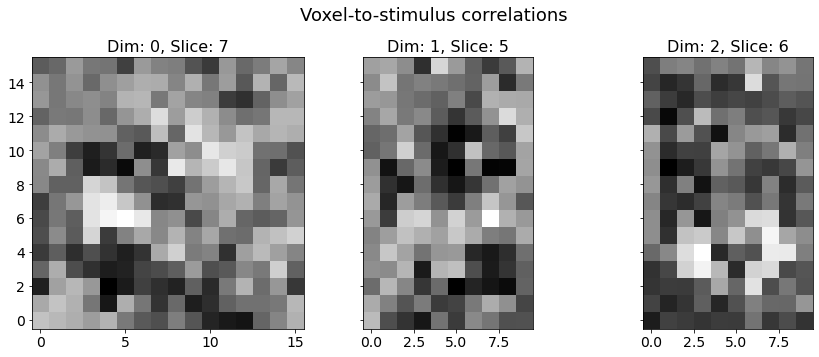

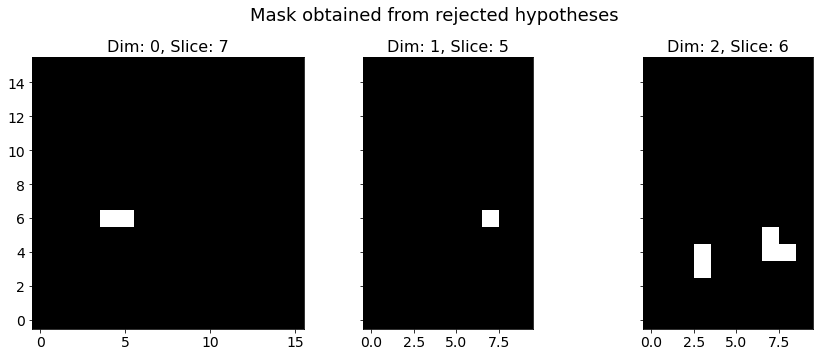

Число областей полученных при статистическом анализе: 8


In [226]:
fMRI_face = X[40]
s_face = s[40]
s_face[s_face!=0]=1

plot_ccw_results(X=fMRI_face, s=s_face, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

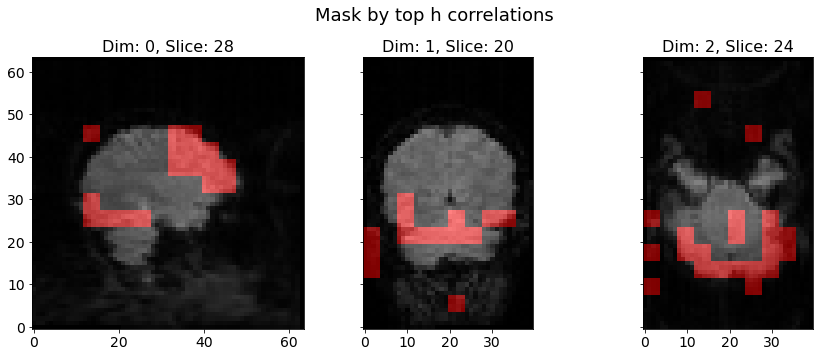

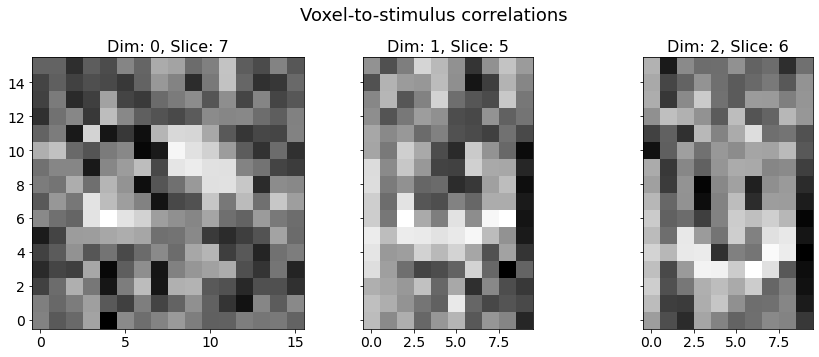

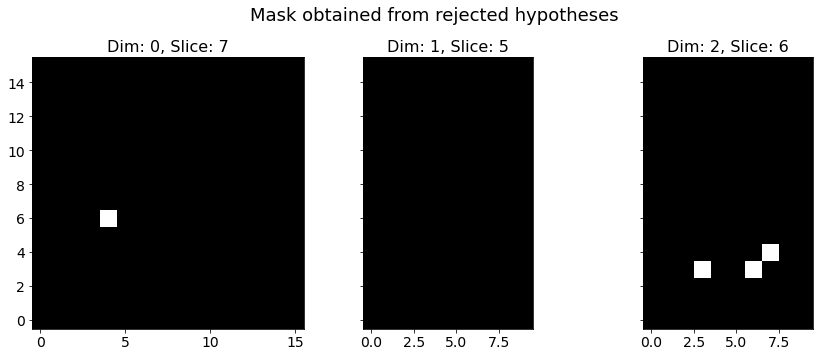

Число областей полученных при статистическом анализе: 4


In [227]:
fMRI_face = X[47]
s_face = s[47]
s_face[s_face!=0]=1

plot_ccw_results(X=fMRI_face, s=s_face, mu=2.5, k_s=4, Delta_t=0, h=100, masked_brain=False)

----

#### Корректность
Эксперимент с шумом, проверим, что выделение областей не случайно, возьмем в качестве вектора стимулов рандомный набор единиц и нулей:

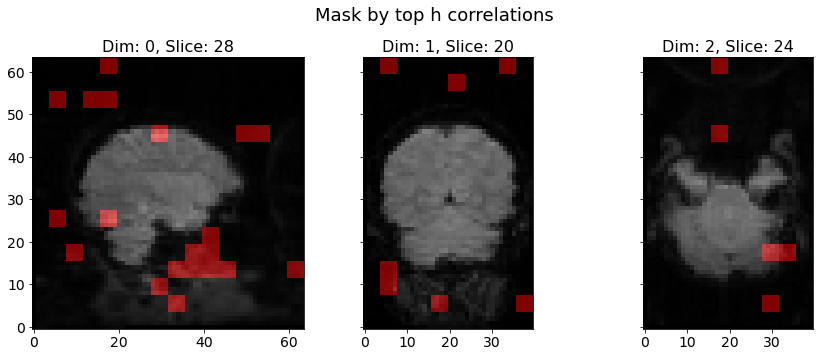

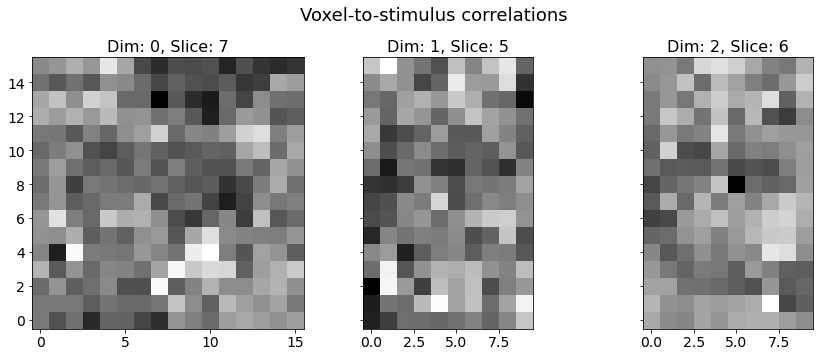

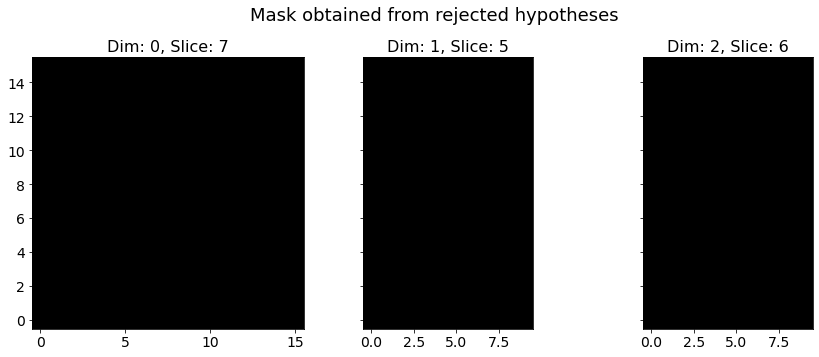

Число областей полученных при статистическом анализе: 0


In [232]:
np.random.seed(10)
rand_s = np.random.randint(0, 2, size=fmris_transposed.shape[0])

plot_ccw_results(X=fmris_transposed, s=rand_s, mu=2.5, k_s=4, Delta_t=0, h=100, masked_brain=False)

---

#### Сегментация мозга

[Метод Оцу](https://engineering.purdue.edu/kak/computervision/ECE661.08/OTSU_paper.pdf) $-$ это алгоритм вычисления порога бинаризации для полутонового изображения, используемый в области компьютерного распознавания образов и обработки изображений для получения чёрно-белых изображений.

Алгоритм позволяет разделить пиксели двух классов («полезные» и «фоновые»), рассчитывая такой порог, чтобы внутриклассовая дисперсия была минимальной. 

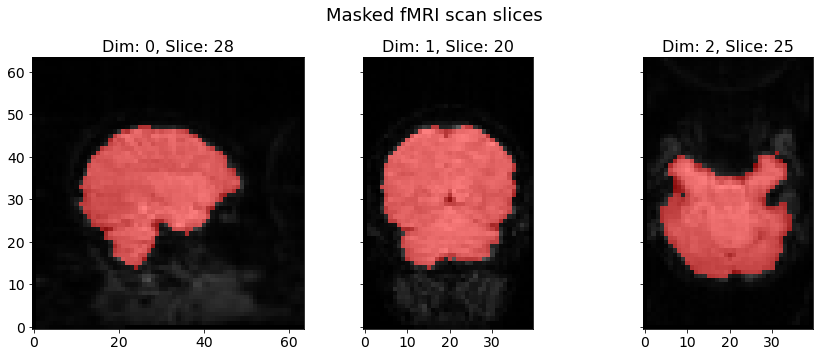

In [235]:
show_scan_slices(fmris_transposed[0], [28, 20, 25], get_otsu_brain_mask(fmris_transposed))

Выделение маски мозга сжатого временного ряда фМРТ

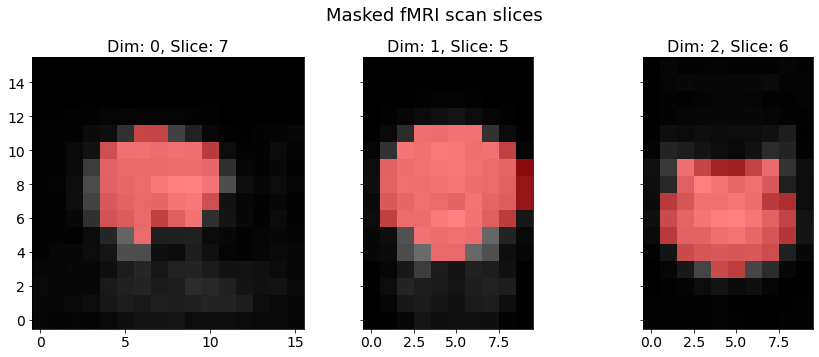

In [238]:
fMRI_compressd_face = F.avg_pool3d(torch.tensor(fMRI_face), kernel_size=4).numpy() # (tau, X/k_s, Y/k_s, Z/k_s)
show_scan_slices(fMRI_compressd_face[0], [7, 5, 6], get_otsu_brain_mask(fMRI_compressd_face))

#### Выделение самых активных вокселей среди только вокселей, относящихся к мозгу

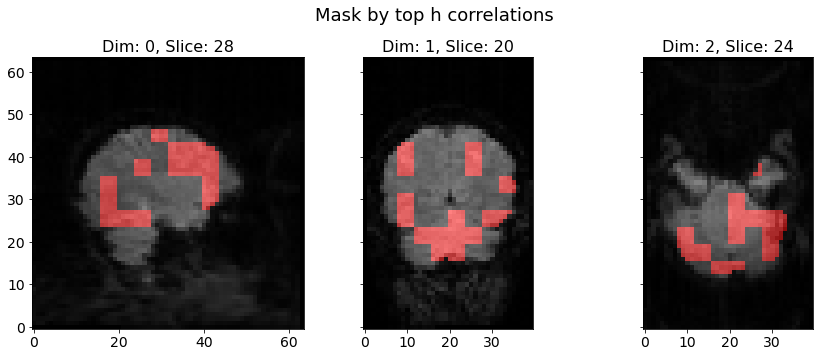

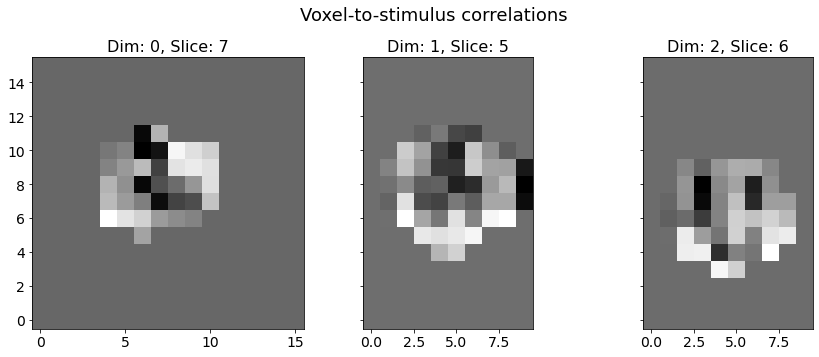

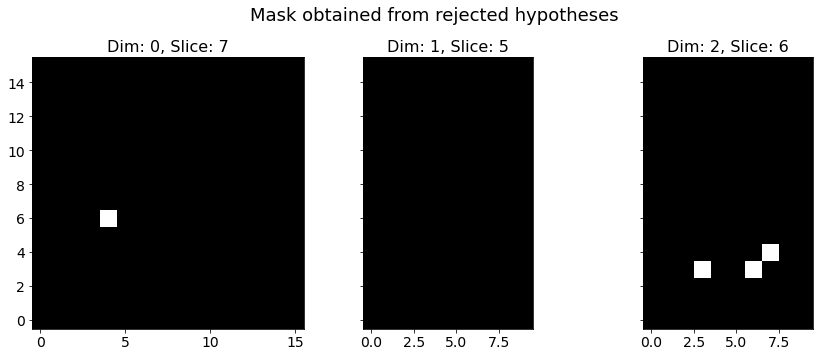

Число областей полученных при статистическом анализе: 4


In [242]:
fMRI_face = X[47]
s_face = s[47]
s_face[s_face!=0]=1

plot_ccw_results(X=fMRI_face, s=s_face, mu=2.5, k_s=4, Delta_t=0, h=100, masked_brain=True)

---
Определение области по временному ряду изменений фМРТ и ряду изменений стимула, то есть рассматриваются временные ряды:
$$\Delta s[t]=s[t+1]-s[t]$$ 
$$\Delta X[t] = X[t+1] - X[t]$$

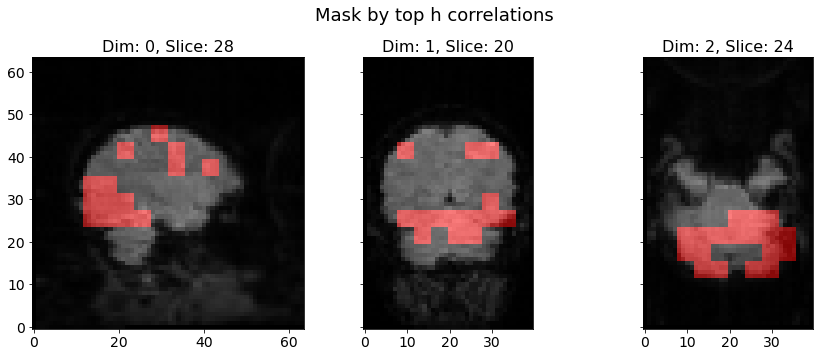

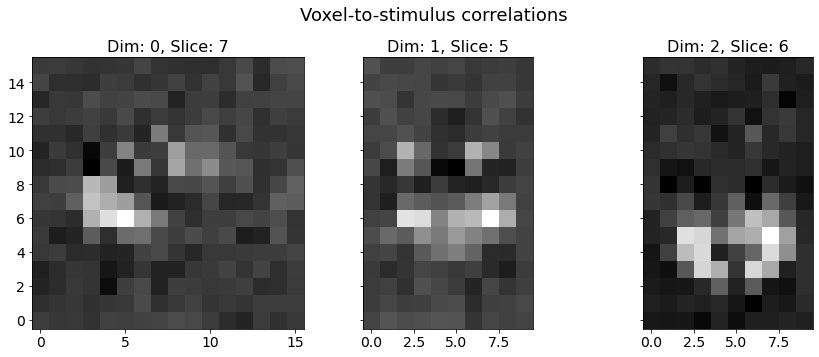

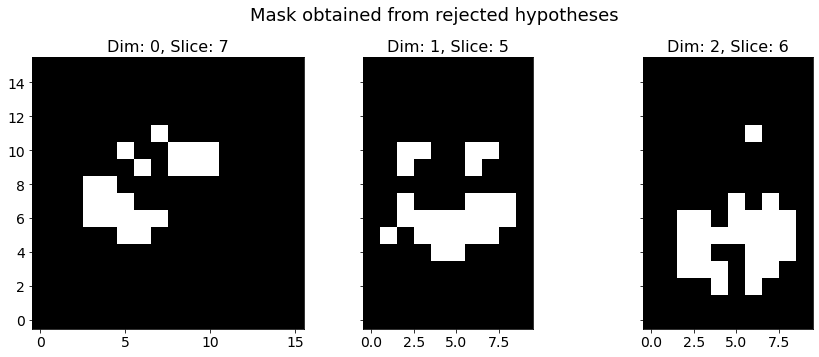

Число областей полученных при статистическом анализе: 136


In [245]:
# По всему временному ряду испытуемого
bin_stimuli = stimuli.copy()
bin_stimuli[bin_stimuli!=0]=1

delta_bin_stimuli = np.diff(bin_stimuli)
delta_fmri = np.diff(fmris_transposed, axis=0)

plot_ccw_results(X=delta_fmri, s=delta_bin_stimuli, mu=2.5, k_s=4, Delta_t=0, h=70, masked_brain=False, mode_delta=True)

Ощущение, что качество стало значительно лучше

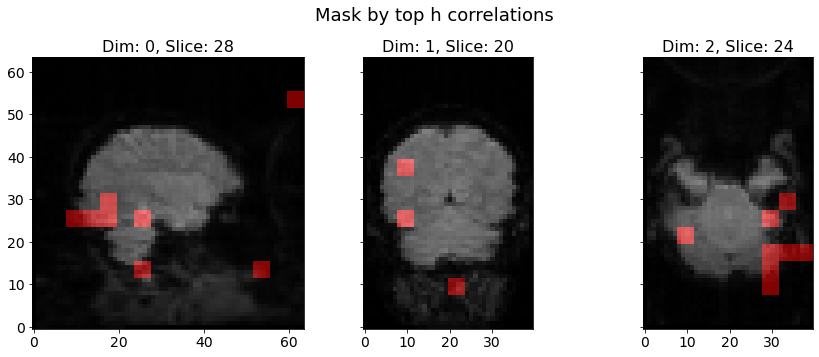

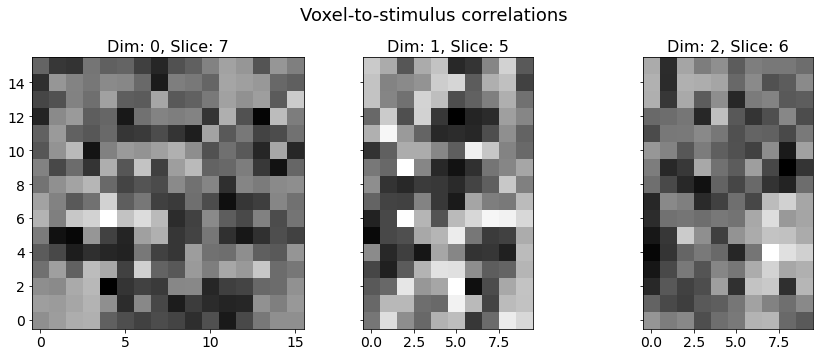

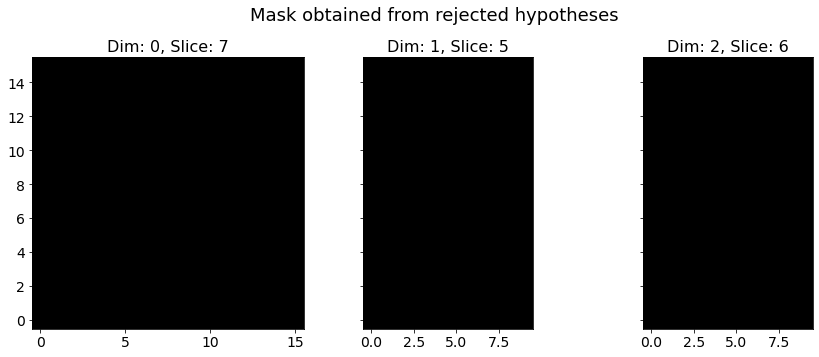

Число областей полученных при статистическом анализе: 0


In [246]:
fMRI_face = X[42].copy()
s_face = s[42].copy()
s_face[s_face!=0]=1
delta_s_face = np.diff(s_face)
delta_fMRI_face = np.diff(fMRI_face, axis=0)

plot_ccw_results(X=delta_fMRI_face, s=delta_s_face, mu=2.5, k_s=4, Delta_t=0, h=70, masked_brain=False, mode_delta=True)

Качество такое себе видимо такой подход чувствителен к длине временного ряда и количеству моментов изменений стимула. Попробуем объединить все временные ряды относящиеся к одной метке и сделать подобный прогноз маски:

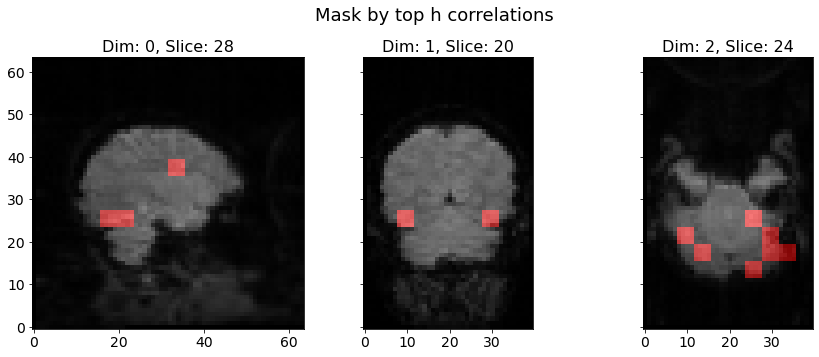

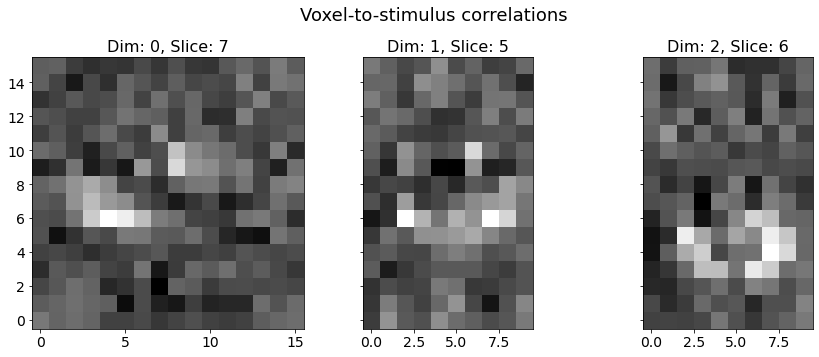

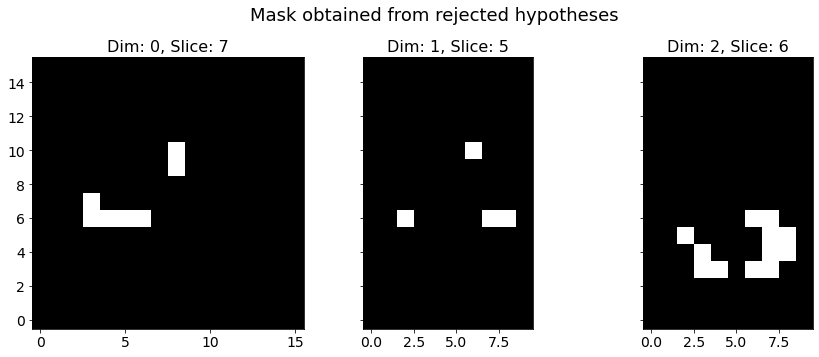

Число областей полученных при статистическом анализе: 23


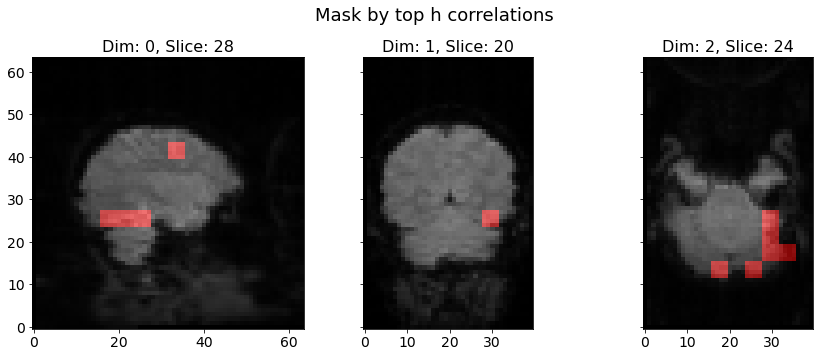

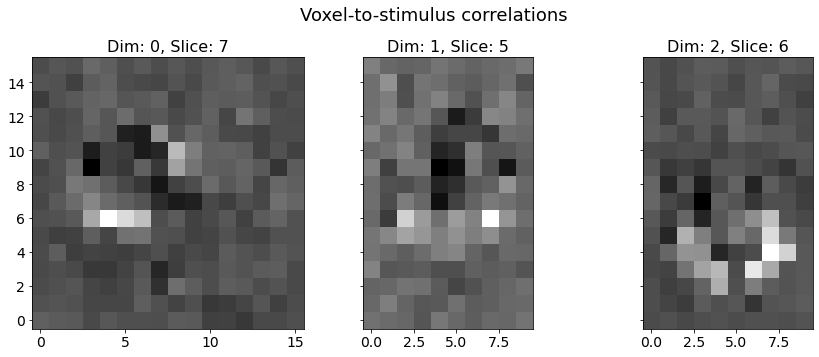

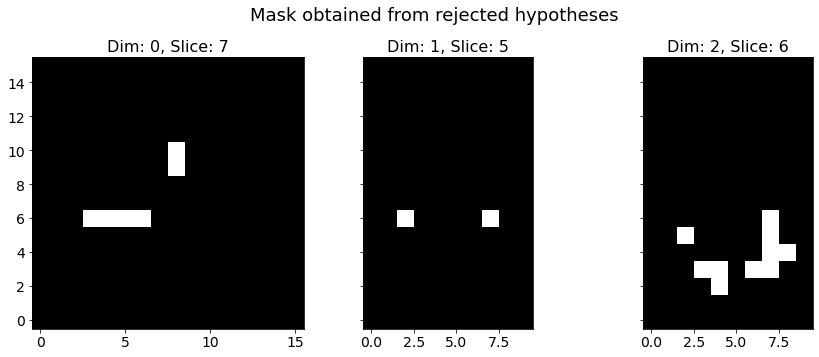

Число областей полученных при статистическом анализе: 21


In [179]:
# 3 соотвествует face
X_cls = X[y==3].copy()
s_cls = s[y==3].copy()
s_cls[s_cls!=0]=1

s_cls = np.concatenate(s_cls, axis=0)
X_cls = np.concatenate(X_cls, axis=0)

delta_s = np.diff(s_cls)
delta_X = np.diff(X_cls, axis=0)

plot_ccw_results(X=delta_X, s=delta_s, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False, mode_delta=True)
plot_ccw_results(X=X_cls, s=s_cls, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

---

### Статистический анализ

tensor([0.7001, 0.6127, 0.6032, 0.5958, 0.5938, 0.5907, 0.5788, 0.5527, 0.5505,
        0.5452])
tensor([2.6492e-210, 2.3123e-146, 1.4404e-140, 3.3120e-136, 4.4647e-135,
        2.7707e-133, 1.3505e-126, 6.1951e-113, 8.1039e-112, 3.2161e-109],
       dtype=torch.float64)


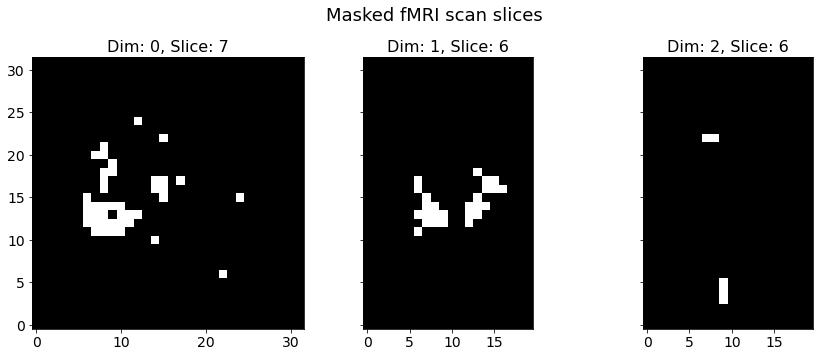

477

In [273]:
k_s = 2
Delta_t = 0.0
mu=2.5
h = 10

bin_stimuli = stimuli.copy()
bin_stimuli[bin_stimuli!=0]=1


# Get active mask using CCW method
active_mask, C, pvalues = ccw(fmris_transposed, bin_stimuli, mu, k_s, Delta_t, h)

_, top_h_indices = torch.topk(torch.tensor(C).view(-1), h)
roi_corr = torch.tensor(C).view(-1)[top_h_indices]
print(roi_corr)
print(torch.tensor(pvalues).view(-1)[top_h_indices])

show_scan_slices(pvalues<0.05, [7, 6, 6], save_img=False)

np.sum(pvalues<0.05)

---

### Реализация метода классификации сегментов временного ряда фМРТ

In [11]:
class classifier():
    def __init__(self, mu, k_s, Delta_t, h, stat_test=False):
        self.mu = mu
        self.k_s = k_s
        self.Delta_t = Delta_t
        self.h = h
        self.stat_test = stat_test
        self.masks = None
        self.preps = None

    def _avg_pool3d(self, X, k_s):
        X = torch.tensor(X).clone()
        return F.avg_pool3d(X, kernel_size=k_s)

    def _ccw(self, X, s, mu, k_s, Delta_t, h, stat_test=True):
        # 1. Input: temporal fMRI series X with sampling rate mu and stimulus time series s
        X = torch.tensor(X).clone() # (tau, X, Y, Z)
        s = torch.tensor(s).clone() # (tau,)

        # 2. 3D Average Pooling
        X_prime = self._avg_pool3d(X, k_s) # (tau, X/k_s, Y/k_s, Z/k_s)

        # 3. Z-normalization of time series
        X_prime_hat = ((X_prime - X_prime.mean(dim=0, keepdims=True)) / (X_prime.std(dim=0) + 1e-9)).float()
        s_hat = ((s.float() - s.float().mean()) / s.float().std()).float()

        # 4. Cross-correlation computation
        tau = X_prime_hat.shape[0]
        C = torch.zeros((tau-1, X_prime_hat.shape[1], X_prime_hat.shape[2], X_prime_hat.shape[3]))
        for p in range(tau-1):
            C[p] = torch.einsum('i,itxy->txy', s_hat[:tau-p], X_prime_hat[p:]) / (tau-1)

        # 5. BOLD Delay and mask computation
        p_BOLD = int(np.floor(Delta_t * mu))
        C_p_BOLD = C[p_BOLD]

        _, top_h_indices = torch.topk(C_p_BOLD.view(-1), h)
        M_c = torch.zeros_like(C_p_BOLD)
        M_c.view(-1)[top_h_indices] = 1
        if not stat_test:
            return M_c
        
        # 6. Perform statistical test and Holm's method
        if stat_test:
            p_values = np.zeros((X_prime_hat.shape[1], X_prime_hat.shape[2], X_prime_hat.shape[3]))
            for i in range(X_prime_hat.shape[1]):
                for j in range(X_prime_hat.shape[2]):
                    for k in range(X_prime_hat.shape[3]):
                        # Perform statistical test
                        _, p_value = pearsonr(s_hat.numpy(), X_prime_hat[:, i, j, k].numpy(), alternative='greater')
                        p_values[i, j, k] = p_value

            # Apply Holm's method for multiple comparisons
            p_values_flattened = p_values.flatten()
            _, corrected_p_values, _, _ = multitest.multipletests(p_values_flattened, method='holm')
            #_, corrected_p_values, _, _ = sm.stats.multipletests(p_values_flattened, alpha=0.05, method='fdr_bh')

            # Reshape and replace original p_values
            corrected_p_values = corrected_p_values.reshape(p_values.shape)
            p_values = corrected_p_values

            M = (p_values<0.05).astype(int)
        return M
        #return M_c.numpy(), C_p_BOLD

    def fit_masks(self, X, s, y):
        self.masks = {}
        for cls in np.unique(y):
            X_cls = X[y==cls].copy()
            s_cls = s[y==cls].copy()
            bin_s = s_cls.copy()
            bin_s[bin_s!=0]=1
            bin_s = np.concatenate(bin_s, axis=0)
            X_cls = np.concatenate(X_cls, axis=0)
            delta_s = np.diff(bin_s)
            delta_X = np.diff(X_cls, axis=0)
            self.masks[cls] = self._ccw(delta_X, delta_s, self.mu, self.k_s, self.Delta_t, self.h, self.stat_test)
            

    def _apply_cls_mask(self, X, cls):
        X = (self._avg_pool3d(X, k_s=self.k_s)).numpy()
        # Expand the mask dimensions to match the fMRI data
        mask = np.expand_dims(self.masks[cls], axis=(0, 1))
        mask = np.tile(mask, (X.shape[0], X.shape[1], 1, 1, 1))

        # Apply the mask to the fMRI data
        masked_X = X * mask
        # Flatten the masked data
        masked_X = masked_X.reshape((masked_X.shape[0], masked_X.shape[1], -1))

        # Remove voxels with zero values
        nonzero_voxels = np.where(self.masks[cls].flatten() > 0)
        masked_X = masked_X[:, :, nonzero_voxels]

        masked_X = np.squeeze(masked_X) 
        masked_X = np.transpose(masked_X, (0, 2, 1))
        return masked_X
    
    def _binarize_rel_labels(self, y, cls):
        bin_y = np.zeros_like(y)
        bin_y[np.where(y==cls)]=1
        return bin_y

    def _fit_tsm(self, masked_X, bin_y):
        covest = Covariances()
        reg = Shrinkage(shrinkage=1e-3)
        ts = TangentSpace()
        preprocess = make_pipeline(covest,reg,ts)
        preprocess.fit(masked_X, bin_y)
        return preprocess
    
    
    def fit(self, X, s, y):
        # извлекаем маски и обучаем римана
        self.fit_masks(X, s, y)
        self.preps = {}
        for cls in np.unique(y):
            masked_X = self._apply_cls_mask(X, cls)
            #print(masked_X.shape)
            bin_y = self._binarize_rel_labels(y, cls)
            prep = self._fit_tsm(masked_X, bin_y)
            self.preps[cls] = prep

    def transform_cls(self, X, cls):
        masked_X = self._apply_cls_mask(X, cls)
        prep_X = self.preps[cls].transform(masked_X)
        return prep_X
    
    def transform(self, X):
        # Окончательно получаем вектора эмбеддингов
        new_X = []
        for cls in np.unique(y):
            masked_X = self._apply_cls_mask(X, cls)
            prep_X = self.preps[cls].transform(masked_X)
            new_X.append(prep_X)
        new_X = np.concatenate(new_X, axis=1)
        return new_X
            

---

Хотим тестировать 1-го, 2-го и 3-го испытуемого:

In [18]:
def get_results_for_sub(num, h=10, stat_test=True):
    dataset = haxby_dataset()

    datafiles = dataset.data_files
    fmris, labels = dataset.get_sub_data(num)

    class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}
    stimuli = np.array([class_dict[label] for label in labels['labels'].values])
    fmris_transposed = fmris.transpose((3, 0, 1, 2))

    X, s, y = extract_segments(fmris_transposed, stimuli, tau=19)
    y=y-1

    X_train, X_test, s_train, s_test, y_train, y_test = train_test_split(X, s, y, test_size=0.20, random_state=42, stratify=y)
    clf = classifier(mu=2.5, k_s=4, Delta_t=0.0, h=10, stat_test=stat_test)
    clf.fit(X_train, s_train, y_train)

    X_ptrain = clf.transform(X_train)
    X_ptest = clf.transform(X_test)

    # 1. Logistic Regression
    lr = LogisticRegression(C=1e2, class_weight='balanced', random_state=42)
    lr.fit(X_ptrain, y_train)
    lr_proba = lr.predict_proba(X_ptest)
    lr_pred = lr.predict(X_ptest)
    #print("Logistic Regression classification report:\n", classification_report(y_test, lr_pred))
    macro_f1_logreg = f1_score(y_test, lr_pred, average='macro')
    micro_f1_logreg = f1_score(y_test, lr_pred, average='micro')
    acc_logreg = accuracy_score(y_test, lr_pred)
    print('Макро и микро среднее значение f1-score:', macro_f1_logreg, micro_f1_logreg)
    print('acc:', acc_logreg)

    # 2. MLP
    clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=200, activation = 'logistic')
    clf.fit(X_ptrain, y_train)

    y_pred = clf.predict(X_ptest)
    #print("\n MLPClassifier report:\n", classification_report(y_test, y_pred, zero_division=1))
    macro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    micro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    acc_mlp = accuracy_score(y_test, y_pred)
    print('Макро и микро среднее значение f1-score:', macro_f1_mlp, micro_f1_mlp)
    print('acc:', acc_mlp)

    return macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp


In [225]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_results_for_sub(1)

Макро и микро среднее значение f1-score: 0.51875 0.55
acc: 0.55
Макро и микро среднее значение f1-score: 0.5732142857142857 0.5732142857142857
acc: 0.65


In [61]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_results_for_sub(2)

Макро и микро среднее значение f1-score: 0.5976190476190476 0.65
acc: 0.65
Макро и микро среднее значение f1-score: 0.6988095238095238 0.6988095238095238
acc: 0.75


In [17]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_results_for_sub(3)

<ipython-input-11-d2a78569b7e3>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).clone()


Макро и микро среднее значение f1-score: 0.5976190476190476 0.65
acc: 0.65


c:\phyton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Макро и микро среднее значение f1-score: 0.6113095238095239 0.6113095238095239
acc: 0.65


### Ablation анализ (отключаем отдельные компоненты метода)
1. Отключаем tangen space mapping, используем выпрямление временных рядов
2. Получим общую маску активности по всем временным рядам из тренировочной выборки + используем tangen space mapping

In [ ]:
def apply_cls_mask(X, M, k_s):
        # Expand the mask dimensions to match the fMRI data
        X = torch.tensor(X)
        X = F.avg_pool3d(X, kernel_size=k_s).numpy()
        mask = np.expand_dims(M, axis=(0, 1))
        mask = np.tile(mask, (X.shape[0], X.shape[1], 1, 1, 1))

        # Apply the mask to the fMRI data
        masked_X = X * mask
        # Flatten the masked data
        masked_X = masked_X.reshape((masked_X.shape[0], masked_X.shape[1], -1))

        # Remove voxels with zero values
        nonzero_voxels = np.where(M.flatten() > 0)
        masked_X = masked_X[:, :, nonzero_voxels]

        masked_X = np.squeeze(masked_X) 
        masked_X = np.transpose(masked_X, (0, 2, 1))
        return masked_X

In [99]:
def get_method1_results_for_sub(num):
    fmris, labels = dataset.get_sub_data(num)

    class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}
    stimuli = np.array([class_dict[label] for label in labels['labels'].values])
    fmris_transposed = fmris.transpose((3, 0, 1, 2))

    X, s, y = extract_segments(fmris_transposed, stimuli, tau=19)
    y=y-1

    X_train, X_test, s_train, s_test, y_train, y_test = train_test_split(X, s, y, test_size=0.20, random_state=42, stratify=y)

    s_train_new = s_train
    s_train_new[np.where(s_train_new!=0)] = 1
    s_train_new = np.concatenate(s_train_new)

    X_train_new = np.concatenate(X_train, axis=0)
    k_s = 4
    M,_,_ = ccw(X=X_train_new, s=s_train_new, mu=2.5, k_s=k_s, Delta_t=0, h=10, masked_brain=False)
    
    X_train_masked = apply_cls_mask(X_train, M, k_s)
    X_test_masked = apply_cls_mask(X_test, M, k_s)

    X_ptest = X_test_masked.reshape((20, -1))
    X_ptrain = X_train_masked.reshape((76, -1))

    # 1. Logistic Regression
    lr = LogisticRegression(C=1e2, class_weight='balanced', random_state=42)
    lr.fit(X_ptrain, y_train)
    lr_proba = lr.predict_proba(X_ptest)
    lr_pred = lr.predict(X_ptest)
    #print("Logistic Regression classification report:\n", classification_report(y_test, lr_pred))
    macro_f1_logreg = f1_score(y_test, lr_pred, average='macro')
    micro_f1_logreg = f1_score(y_test, lr_pred, average='micro')
    acc_logreg = accuracy_score(y_test, lr_pred)
    print('Макро и микро среднее значение f1-score:', macro_f1_logreg, micro_f1_logreg)
    print('acc:', acc_logreg)

    # 2. MLP
    clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=200, activation = 'logistic')
    clf.fit(X_ptrain, y_train)

    y_pred = clf.predict(X_ptest)
    #print("\n MLPClassifier report:\n", classification_report(y_test, y_pred, zero_division=1))
    macro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    micro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    acc_mlp = accuracy_score(y_test, y_pred)
    print('Макро и микро среднее значение f1-score:', macro_f1_mlp, micro_f1_mlp)
    print('acc:', acc_mlp)

    return macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp


In [231]:
def get_method2_results_for_sub(num):
    fmris, labels = dataset.get_sub_data(num)

    class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}
    stimuli = np.array([class_dict[label] for label in labels['labels'].values])
    fmris_transposed = fmris.transpose((3, 0, 1, 2))

    X, s, y = extract_segments(fmris_transposed, stimuli, tau=19)
    y=y-1

    X_train, X_test, s_train, s_test, y_train, y_test = train_test_split(X, s, y, test_size=0.20, random_state=42, stratify=y)

    s_train_new = s_train
    s_train_new[np.where(s_train_new!=0)] = 1
    s_train_new = np.concatenate(s_train_new)

    X_train_new = np.concatenate(X_train, axis=0)
    k_s = 4
    M,_,_ = ccw(X=X_train_new, s=s_train_new, mu=2.5, k_s=k_s, Delta_t=0, h=10, masked_brain=False)
    
    X_train_masked = apply_cls_mask(X_train, M, k_s)
    X_test_masked = apply_cls_mask(X_test, M, k_s)

    covest = Covariances()
    reg = Shrinkage(shrinkage=1e-3)
    ts = TangentSpace()
    preprocess = make_pipeline(covest,reg,ts)
    preprocess.fit(X_train_masked)

    X_ptrain = preprocess.transform(X_train_masked)

    X_test_masked = apply_cls_mask(X_test, M, k_s)
    X_ptest = preprocess.transform(X_test_masked)

    # 1. Logistic Regression
    lr = LogisticRegression(C=1e2, class_weight='balanced', random_state=42)
    lr.fit(X_ptrain, y_train)
    lr_proba = lr.predict_proba(X_ptest)
    lr_pred = lr.predict(X_ptest)
    #print("Logistic Regression classification report:\n", classification_report(y_test, lr_pred))
    macro_f1_logreg = f1_score(y_test, lr_pred, average='macro')
    micro_f1_logreg = f1_score(y_test, lr_pred, average='micro')
    acc_logreg = accuracy_score(y_test, lr_pred)
    print('Макро и микро среднее значение f1-score:', macro_f1_logreg, micro_f1_logreg)
    print('acc:', acc_logreg)

    # 2. MLP
    clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=200, activation = 'logistic')
    clf.fit(X_ptrain, y_train)

    y_pred = clf.predict(X_ptest)
    #print("\n MLPClassifier report:\n", classification_report(y_test, y_pred, zero_division=1))
    macro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    micro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    acc_mlp = accuracy_score(y_test, y_pred)
    print('Макро и микро среднее значение f1-score:', macro_f1_mlp, micro_f1_mlp)
    print('acc:', acc_mlp)

    return macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp


In [232]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_method1_results_for_sub(2)

Макро и микро среднее значение f1-score: 0.12142857142857144 0.15
acc: 0.15
Макро и микро среднее значение f1-score: 0.022727272727272728 0.022727272727272728
acc: 0.1


In [233]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_method2_results_for_sub(2)

Макро и микро среднее значение f1-score: 0.3755952380952381 0.4000000000000001
acc: 0.4
Макро и микро среднее значение f1-score: 0.3104166666666666 0.3104166666666666
acc: 0.4


### Другие эксперименты:

In [166]:
X_train, X_test, s_train, s_test, y_train, y_test = train_test_split(X, s, y, test_size=0.20, random_state=42, stratify=y)
clf = classifier(mu=2.5, k_s=4, Delta_t=0.0, h=10)
clf.fit(X_train, s_train, y_train)

X_ptrain = clf.transform_cls(X_train, 3)
X_ptest = clf.transform_cls(X_test, 3)

y_ptrain = np.zeros_like(y_train)
y_ptrain[y_train==3]=1
y_ptest = np.zeros_like(y_test)
y_ptest[y_test==3]=1

In [167]:
X_ptrain.shape

(76, 15)

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 1. Logistic Regression
lr = LogisticRegression(C=1e1, class_weight='balanced', random_state=42)
lr.fit(X_ptrain, y_ptrain)
lr_proba = lr.predict_proba(X_ptest)
lr_pred = lr.predict(X_ptest)
print("Logistic Regression classification report:\n", classification_report(y_ptest, lr_pred))

# 2. Support Vector Machines
svm = SVC(C=1e2, class_weight='balanced', probability=True, random_state=42)
svm.fit(X_ptrain, y_ptrain)
svm_proba = svm.predict_proba(X_ptest)
svm_pred = svm.predict(X_ptest)
print("\nSVM classification report:\n", classification_report(y_ptest, svm_pred))

# 3. Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_ptrain, y_ptrain)
rf_proba = rf.predict_proba(X_ptest)
rf_pred = rf.predict(X_ptest)
print("\nRandom Forest classification report:\n", classification_report(y_ptest, rf_pred))

# Hyperparameter tuning example using GridSearchCV for Logistic Regression
params = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
lr_gs = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), params, cv=5, scoring='roc_auc', refit='roc_auc')
lr_gs.fit(X_ptrain, y_ptrain)
print("\nBest hyperparameters for Logistic Regression:", lr_gs.best_params_)

Logistic Regression classification report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        17
           1       0.60      1.00      0.75         3

    accuracy                           0.90        20
   macro avg       0.80      0.94      0.84        20
weighted avg       0.94      0.90      0.91        20


SVM classification report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.50      0.33      0.40         3

    accuracy                           0.85        20
   macro avg       0.69      0.64      0.66        20
weighted avg       0.83      0.85      0.84        20


Random Forest classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.33      0.50         3

    accuracy                           0.90        20
   macro avg    